In [249]:
import pandas as pd
import numpy as np
from datetime import datetime

from scikit_posthocs import posthoc_mannwhitney
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection, multipletests
from scipy import stats
from mlxtend.evaluate import permutation_test
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.base import clone
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.linear_model import LogisticRegression, LassoLars

# 1. Описание исходных данных и предобработка

Для анализа использовались результаты двух исследований иммунной терапии aPD1 на данных анализа образцов опухолей пациентов: DOI: 10.1016/j.cell.2016.02.065 (данные - GSE78220), 10.1016/j.celrep.2017.04.031 (данные - GSE96619).

В первой работе было исследовано 28 образцов, во второй - 10 образцов (5 пациентов).

В исследованиях был проведен эксперимент RNA-seq на образцах биопсии меланомы перед anti-PD-1 терапией (во втором исследовании также был проведен второй эксперимент RNA-seq во время терапии). 

В исследованиях уже была проведена обработка исходных данных RNA-seq, результат обработки представляет из себя таблицу с FPKM значениями экспрессии генов.

В первом эксперименте доступны данные по экспрессии генов 28 пациентов, 27 из которых были взяты перед терапией (в дальнейшем мы не будем использовать данные по пациенту, образцы которого были взяты во время терапии для построения модели).

Во втором эксперименте доступны данные по 5 пациентам, для всех них есть данные перед терапией.

Посмотрим на данные по экспрессии генов из обоих исследований. 

Данные из первого исследования:

In [2]:
gene_expression_r1 = pd.read_excel('data/r1/GSE78220_PatientFPKM.xlsx', index_col=0)

/Users/nikitakonstantinovskiy/opt/anaconda3/envs/aPD1_therapy_response/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
gene_expression_r1.head()

,Pt1.baseline,Pt2.baseline,Pt4.baseline,Pt5.baseline,Pt6.baseline,Pt7.baseline,Pt8.baseline,Pt9.baseline,Pt10.baseline,Pt12.baseline,...,Pt25.baseline,Pt27A.baseline,Pt27B.baseline,Pt28.baseline,Pt29.baseline,Pt31.baseline,Pt32.baseline,Pt35.baseline,Pt37.baseline,Pt38.baseline
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,8.025380,317.594000,5.747295,6.859570,1.563465,21.565850,11.370550,8.156810,4.346750,6.508715,...,40.408950,6.093810,7.191755,8.595985,5.460340,14.788600,17.377200,11.644200,15.000300,4.475170
A1BG-AS1,0.677503,28.378200,0.471394,0.347623,0.201760,8.926245,3.853125,2.539610,1.914350,4.797930,...,0.441924,0.265769,0.513015,1.314753,3.155180,0.254531,0.673230,0.718414,0.388571,0.253978
A1CF,0.000000,18.109400,0.000000,0.000000,0.011276,0.000000,0.003263,0.001398,0.000000,0.000000,...,0.000000,0.000000,0.001768,0.188226,0.009519,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,185.304000,455.160000,81.008200,41.410650,136.163500,44.669350,119.017500,232.675000,501.697000,530.237500,...,300.813000,390.299500,364.513500,67.114500,557.991500,50.436000,121.544000,55.713900,39.667300,495.157000
A2M-AS1,0.363531,2.864455,0.201285,0.040821,0.417423,1.039475,3.126025,4.216800,1.489845,1.868520,...,2.511090,0.397716,0.284776,0.627700,1.295220,0.129179,0.824253,0.172745,1.587210,1.049580


In [4]:
gene_expression_r1.shape

(25268, 28)

In [5]:
gene_expression_r1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25268 entries, A1BG to ZZZ3
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pt1.baseline    25268 non-null  float64
 1   Pt2.baseline    25268 non-null  float64
 2   Pt4.baseline    25268 non-null  float64
 3   Pt5.baseline    25268 non-null  float64
 4   Pt6.baseline    25268 non-null  float64
 5   Pt7.baseline    25268 non-null  float64
 6   Pt8.baseline    25268 non-null  float64
 7   Pt9.baseline    25268 non-null  float64
 8   Pt10.baseline   25268 non-null  float64
 9   Pt12.baseline   25268 non-null  float64
 10  Pt13.baseline   25268 non-null  float64
 11  Pt14.baseline   25268 non-null  float64
 12  Pt15.baseline   25268 non-null  float64
 13  Pt16.OnTx       25268 non-null  float64
 14  Pt19.baseline   25268 non-null  float64
 15  Pt20.baseline   25268 non-null  float64
 16  Pt22.baseline   25268 non-null  float64
 17  Pt23.baseline   25268 non-null  fl

In [6]:
gene_expression_r2 = pd.read_excel('data/r2/GSE96619_PatientFPKM.xlsx', index_col=0)

/Users/nikitakonstantinovskiy/opt/anaconda3/envs/aPD1_therapy_response/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [7]:
gene_expression_r2.head()

,Pt1-OnTx,Pt1-baseline,Pt2-OnTx,Pt2-baseline,Pt3-OnTx,Pt3-baseline,Pt4-OnTx,Pt4-baseline,Pt5-OnTx,Pt5-baseline
Gene,,,,,,,,,,
A1BG,8.411245,6.887730,12.144350,32.177600,5.835355,4.306105,6.530260,6.420020,8.307430,12.274900
A1BG-AS1,1.373575,0.349027,0.977777,0.754818,1.458905,1.896455,4.813830,0.873906,0.397611,0.841965
A1CF,0.001914,0.000000,0.002021,0.001738,0.001414,0.000000,0.000000,0.002402,0.000000,0.001578
A2M,106.640500,41.582300,306.499500,189.732500,499.497000,497.008000,531.984000,407.300500,409.396500,240.788500
A2M-AS1,0.057771,0.040971,1.981470,1.831725,1.936515,1.475915,1.874585,1.262840,1.439495,1.133830


In [8]:
gene_expression_r2.shape

(25268, 10)

In [9]:
gene_expression_r2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25268 entries, A1BG to ZZZ3
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pt1-OnTx      25268 non-null  float64
 1   Pt1-baseline  25268 non-null  float64
 2   Pt2-OnTx      25268 non-null  float64
 3   Pt2-baseline  25268 non-null  float64
 4   Pt3-OnTx      25268 non-null  float64
 5   Pt3-baseline  25268 non-null  float64
 6   Pt4-OnTx      25268 non-null  float64
 7   Pt4-baseline  25268 non-null  float64
 8   Pt5-OnTx      25268 non-null  float64
 9   Pt5-baseline  25268 non-null  float64
dtypes: float64(10)
memory usage: 2.1+ MB


Видно, что NaN значений в данных нет.

Также в первом датасете есть один пациент, данные по которому были получены уже во время применения терапии (это понятно из статьи, а также по названию колонки, его мы исключим из датасета). 

Помимо этого для первого датасета досупны данные по мутациям для каждого пациента. Мы могли бы использовать эти данные для увеличения точности модели, однако, таких данных недоступно для второго датасета, на котором будет проводиться тестирование точности модели, поэтому мы не сможем использовать их для обучения модели. 

Далее проведем первый этап предобработки данных, исключим данные, которые были собраны во время терапии, проверим что порядок генов в обоих датасетах соответствует и проведем транпонирование датасетов (сделаем так, чтобы пациенты были строками – наблюдениями, а гены столбцами – фичами) и добавим аннотацию по ответу на терапию у пациентов. Для первого датасета мы используем данные доступные из supplementary materials для аннотации, для второго получим аннотирование вручную из текста статьи.

In [10]:
# исключаем данные собранные во время терапии
train = gene_expression_r1[gene_expression_r1.columns.drop(list(gene_expression_r1.filter(regex='.*OnTx$')))]
test = gene_expression_r2[gene_expression_r2.columns.drop(list(gene_expression_r2.filter(regex='.*OnTx$')))]

In [11]:
# проверяем, совпадают ли названия генов в тренировочном и тестовом датасете
is_equal = train.index == test.index
np.all(is_equal)

False

Не совпадают, посмотрим где

In [12]:
train.index[np.where(np.invert(is_equal))[0]]

Index(['ANO10', 'ANO1-AS2', 'ARHGEF33', 'ARHGEF34P', 'ARHGEF35', 'ARHGEF37',
       'ARHGEF38', 'ARHGEF38-IT1', 'ARHGEF39', 'ARHGEF3-AS1',
       ...
       'ZNF320', 'ZNF321P', 'ZNF322', 'ZNF324', 'ZNF324B', 'ZNF326', 'ZNF329',
       'ZNF32-AS1', 'ZNF32-AS2', 'ZNF32-AS3'],
      dtype='object', name='Gene', length=1222)

In [13]:
test.index[np.where(np.invert(is_equal))[0]]

Index([    'ANO1-AS2',        'ANO10',  'ARHGEF3-AS1',     'ARHGEF33',
          'ARHGEF34P',     'ARHGEF35',     'ARHGEF37',     'ARHGEF38',
       'ARHGEF38-IT1',     'ARHGEF39',
       ...
          'ZNF32-AS1',    'ZNF32-AS2',    'ZNF32-AS3',       'ZNF320',
            'ZNF321P',       'ZNF322',       'ZNF324',      'ZNF324B',
             'ZNF326',       'ZNF329'],
      dtype='object', name='Gene', length=1222)

Сначала было предположение, что дело в сортировке названия генов, однако после просмотра файлов стало понятно что дело в том как был сохранен второй файл, имена некоторых генов совпадают с названиями дат и эксель автоматически конвертирует их в тип datetime. Это известная проблема, найдем все такие гены и переименуем в строки.

In [14]:
# посмотрим какие значения индекса имеют тип datetime в тестовом датасете
idx_dt_test = np.where(test.index.map(lambda x: isinstance(x, datetime)))[0]
test.index[idx_dt_test]

Index([2017-12-01 00:00:00, 2017-03-01 00:00:00, 2017-03-02 00:00:00,
       2017-03-01 00:00:00, 2017-03-10 00:00:00, 2017-03-11 00:00:00,
       2017-03-02 00:00:00, 2017-03-03 00:00:00, 2017-03-04 00:00:00,
       2017-03-05 00:00:00, 2017-03-06 00:00:00, 2017-03-07 00:00:00,
       2017-03-08 00:00:00, 2017-03-09 00:00:00, 2017-09-15 00:00:00,
       2017-09-01 00:00:00, 2017-09-10 00:00:00, 2017-09-11 00:00:00,
       2017-09-12 00:00:00, 2017-09-14 00:00:00, 2017-09-02 00:00:00,
       2017-09-03 00:00:00, 2017-09-04 00:00:00, 2017-09-05 00:00:00,
       2017-09-06 00:00:00, 2017-09-07 00:00:00, 2017-09-08 00:00:00,
       2017-09-09 00:00:00],
      dtype='object', name='Gene')

In [15]:
# тоже самое для тренировочного
idx_dt_train = np.where(train.index.map(lambda x: isinstance(x, datetime)))[0]
train.index[idx_dt_train]

Index([], dtype='object', name='Gene')

В тренировочном датасете таких значений нет, в тестовом заменим их. Для правильных названий посмотрим что в тех же позициях у тренировочного датасета.

In [16]:
train.index[idx_dt_test]

Index(['DEC1', 'MARC1', 'MARC2', 'MARCH1', 'MARCH10', 'MARCH11', 'MARCH2',
       'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9',
       'SEP15', 'SEPT1', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14', 'SEPT2',
       'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'],
      dtype='object', name='Gene')

Тут видно что порядок совпадает, так что просто возьмем названия из тренировочного датасета в том же порядке.

In [17]:
new_index = test.index.tolist()

for i in idx_dt_test:
    new_index[i] = train.index[i]

test.index = new_index

In [18]:
# еще раз проверим
idx_dt_test = np.where(test.index.map(lambda x: isinstance(x, datetime)))[0]
test.index[idx_dt_test]

Index([], dtype='object')

Теперь дат нет, отсортируем гены и еще раз проверим совпадение названий генов.

In [19]:
train = train.sort_index(axis=0)
test = test.sort_index(axis=0)
is_equal = train.index == test.index
np.all(is_equal)

True

Теперь все ок. 

In [20]:
# транспонируем датасеты
train = train.T
test = test.T

Получим данные по аннотации Response/No Response. Для первого датасета мы будем использовать данные из supplementary materials, таблица S1B. В этой работе есть более детальные данные по ответу на терапию (в том числе можно найти информацию о том, был ли ответ на терапию полным или нет), однако таких данных для второго датасета у нас нет, так что ограничимся аннотацией Response/No Response.

Также можно заметить, что у пациента 27 была взята биопсия два раза, оба раза до терапии. В целом такое удвоение данных должно быть приемлемо в нашем анализе, так как опухоль может иметь различный уровень экспрессии генов в разных местах, что должно дать дополнительную информацию для модели.

In [21]:
# получаем все данные доступные из таблицы S1B
annotation_data = pd.read_excel('data/r1/mmc1.xls', index_col=0, sheet_name='S1B', header=2)
annotation_data.head()

,BRCA2mutant?,IPRES signature,Response,Purity,Ploidy,AvgCov,PctCov15,TotalNonSyn,TotalNonSyn_Exp,TotalIndelNonSyn,...,A>C,A>T,C>A,C>G,A>G.frac,C>T.frac,A>C.frac,A>T.frac,C>A.frac,C>G.frac
Patient ID,,,,,,,,,,,,,,,,,,,,,
Pt1,1.0,Y,NR,0.25,5.4,126.61,95.5,1645.0,1394.0,0.0,...,97.0,233.0,176.0,54.0,0.034006,0.906854,0.010244,0.024607,0.018587,0.005703
Pt2,0.0,N,R,0.53,3.9,126.83,97.5,1943.0,1699.0,6.0,...,240.0,527.0,288.0,190.0,0.050542,0.861329,0.016989,0.037304,0.020386,0.013449
Pt3,1.0,na,R,0.79,2.2,91.44,96.6,1146.0,0.0,10.0,...,87.0,98.0,73.0,53.0,0.041279,0.901918,0.015890,0.017900,0.013333,0.009680
Pt4,1.0,N,R,0.74,3.7,127.77,96.0,3985.0,3438.0,19.0,...,508.0,1024.0,529.0,378.0,0.064075,0.842512,0.019456,0.039219,0.020260,0.014477
Pt5,0.0,N,R,0.89,3.4,102.26,95.8,316.0,276.0,2.0,...,46.0,61.0,60.0,31.0,0.061333,0.833067,0.024533,0.032533,0.032000,0.016533


In [22]:
# уберем суффикс .baseline и -baseline из первого и второго датасета, 
# для второго датасета добавим суффикс t чтобы названия пациентов не совпадали
train.index = train.index.str.split('.').str[0]
test.index = test.index.str.split('-').str[0]
test.index = test.index + 't'

In [65]:
train.index

Index(['Pt1', 'Pt2', 'Pt4', 'Pt5', 'Pt6', 'Pt7', 'Pt8', 'Pt9', 'Pt10', 'Pt12',
       'Pt13', 'Pt14', 'Pt15', 'Pt19', 'Pt20', 'Pt22', 'Pt23', 'Pt25', 'Pt27A',
       'Pt27B', 'Pt28', 'Pt29', 'Pt31', 'Pt32', 'Pt35', 'Pt37', 'Pt38'],
      dtype='object')

In [64]:
test.index

Index(['Pt1t', 'Pt2t', 'Pt3t', 'Pt4t', 'Pt5t'], dtype='object')

Теперь создадим аннотацию.

In [27]:
# Для тренировочного датасета
label_map = {'NR': 0, 'R': 1}

y_train = annotation_data.loc[train.index.str.strip('AB').tolist(), 'Response']

y_train = y_train.map(label_map)

Для тестового датасета берем аннотацию из статьи:

in biopsy specimens from five patients responding (red, n = 2) or not responding (black, n = 3) to anti-PD-1 therapy

<img src="img/1.png">

In [28]:
y_test = ['R', 'R', 'NR', 'NR', 'NR']
y_test = np.vectorize(label_map.get)(y_test)

И создадим объединенный датасет с данными по экспрессии генов, для анализа экспрессии из обоих исследований.

In [29]:
data = pd.concat([train, test])

In [30]:
y_data = np.concatenate([y_train, y_test])

# 2. Анализ экспрессии генов из обоих исследований

В начале я попробовал найти дифференциально экспрессируемые гены между пациентами с ответом на терапию и без при помощи статистического теста Манна-Уитни и затем сделав FDR поправку на множественное сравнение

In [241]:
genes_pvals = []

for c in data.columns:
    try:
        pval = mannwhitneyu(data[c][y_data == 0], data[c][y_data == 1], alternative='two-sided')[1]
        genes_pvals.append((c, pval))
    except:
        continue

In [265]:
genes_pvals = pd.DataFrame(genes_pvals)

In [266]:
hyp, ajpval = fdrcorrection(genes_pvals[1], alpha=0.1)
np.where(hyp)

(array([], dtype=int64),)

Однако такой метод не выявил статистически значимых отличий в экспрессии. Тут дело в поправке на множественное ставнение, при таком большом количестве сравниваемых генов (мы сравниваем все экспрессируемые гены), дифференциально экспрессируемые гены могут отклоняться.

После этого я хотел обратиться к тулу DeSeq2 для проведения анализа дифф экспрессии. Однако он не работает с FPKM данными по экспрессии, необходимо было проводить анализ исходных данных RNA-seq, однако такой возможности у меня не было из-за отсутствия достаточных вычислительных мощностей.

Почитав первую статью, я увидел что они использовали p-val 0.25 для своих тестов. Кажется это слишком большое p значение, однако попробуем сделать также:

In [287]:
hyp, ajpval = fdrcorrection(genes_pvals[1], alpha=0.25)
sign_gene_names = genes_pvals[0].values[np.where(hyp)[0]]
sign_padj = ajpval[np.where(hyp)[0]]
sign_genes = pd.DataFrame({'gene': sign_gene_names, 'padj': sign_padj})
sign_genes = sign_genes.sort_values('padj')
sign_genes

,gene,padj
464,LOC101929532,0.218249
681,RNF152,0.218249
383,ITPRIPL1,0.218249
682,RNF43,0.218249
381,ITGBL1,0.218249
...,...,...
353,HOXA13,0.249692
70,BMP1,0.249692
349,HIST1H2AB,0.249692
399,KIAA1462,0.249692


Построим графики экспрессии по нескольким из самых значимых генов:

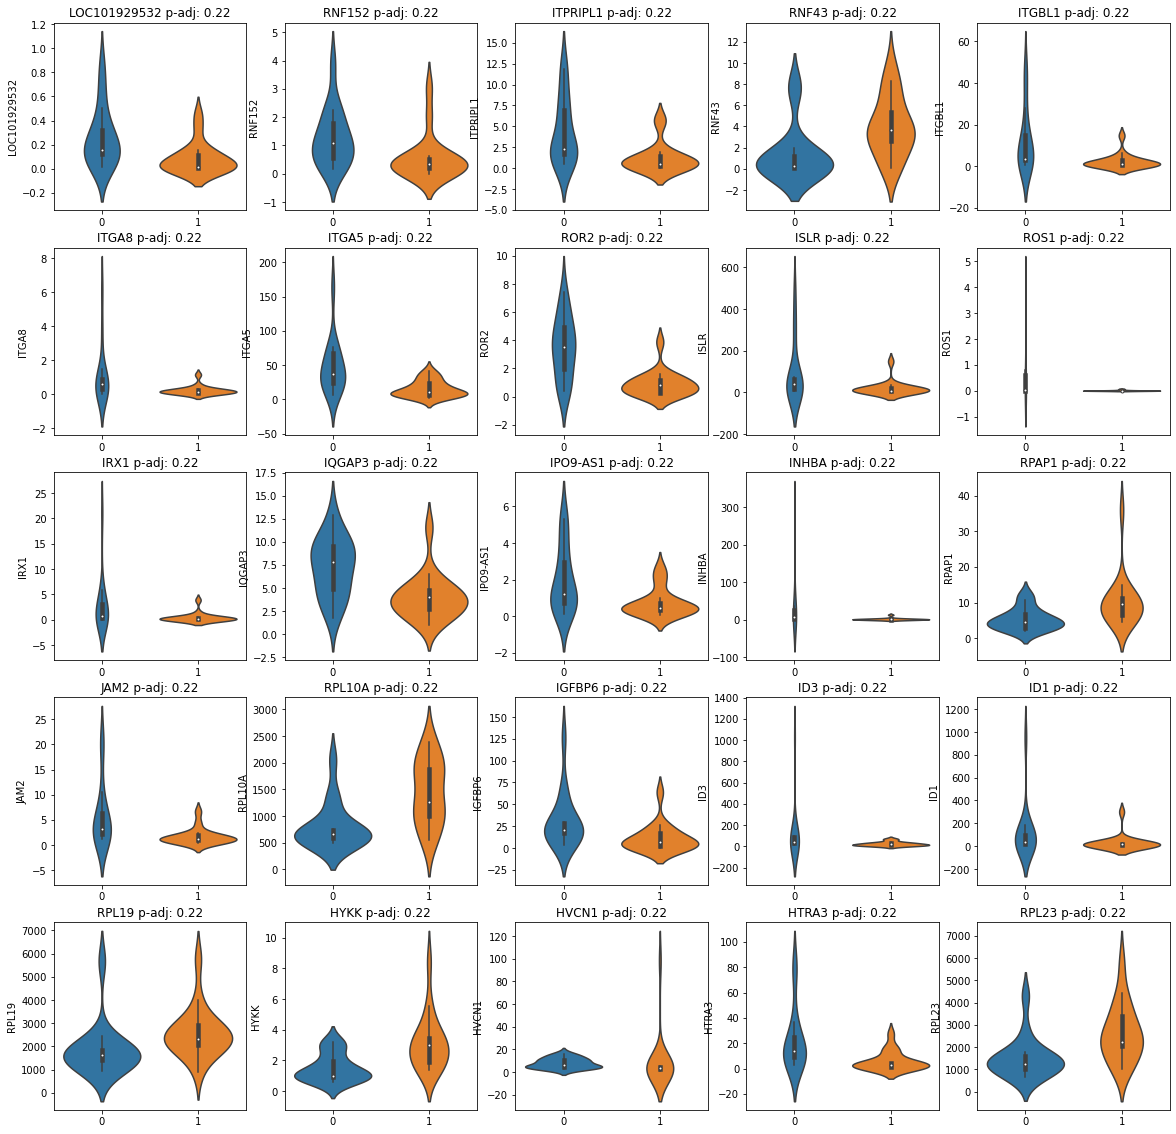

In [301]:
fig = plt.figure(figsize=(20, 20))

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    sns.violinplot(x=y_data, y=data[sign_genes.gene.iloc[i]]).set_title(f'{sign_genes.gene.iloc[i]} p-adj: {sign_genes.padj.iloc[i]:.2f}' )

plt.show()

Видно что экспрессии у них действительно разные. Однако чтобы детальнее понять их роль в ответе на терапию нужно более детально изучать их функции.

Теперь попробуем провести PCA и определить какие фичи наиболее информативны. 

Для этого проведем PCA анализ, перемножим матрицы с исходными данными и результатами PCA, нормализуем полученный результат и умножим на важность компонент.

In [113]:
scaler = StandardScaler()
X = scaler.fit_transform(data)

pca = PCA().fit(X)
X_pca = pca.transform(X)

Z = np.zeros((X_pca.shape[0], X.shape[1] - X_pca.shape[1]))

explained_variance_ratio = np.append(pca.explained_variance_ratio_, np.zeros((1, X.shape[1] - X_pca.shape[1])))

X_pca = np.concatenate([X_pca, Z], axis=1)

In [116]:
dot_matrix = np.dot(X.T, X_pca)
dot_matrix.shape

(25268, 25268)

In [117]:
df_dot_matrix = pd.DataFrame(dot_matrix)
df_dot_matrix.columns = [''.join(['PC', f'{i+1}']) for i in range(dot_matrix.shape[0])]
df_dot_matrix.index = data.columns
df_dot_matrix

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC25259,PC25260,PC25261,PC25262,PC25263,PC25264,PC25265,PC25266,PC25267,PC25268
A1BG,-73.819671,-286.784133,225.260994,222.547255,-138.780505,609.453121,-342.122105,500.260128,-227.721624,103.929977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,-270.962365,-137.255295,230.865365,191.127697,-188.088505,533.462506,-378.259470,490.954082,-148.072491,239.436004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,-275.588414,-241.113319,260.202594,197.715458,-78.338393,581.558741,-396.891013,505.646855,-224.626158,94.546934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,-679.841781,479.233090,-137.116204,384.070268,-182.671955,144.557779,-346.586565,5.080022,139.825657,-49.978115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,210.487106,189.239805,10.149041,431.749020,-522.877693,412.840874,-10.366217,187.748695,66.178033,79.586421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,137.888248,9.966376,21.592992,-13.592572,-71.397915,-4.292951,45.299373,-61.524686,100.891807,277.619069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYG11B,-984.736906,-149.087758,-144.460796,249.380565,397.020659,149.999592,152.908972,-94.286927,48.300253,188.491015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYX,236.225715,515.650802,-333.217528,-168.428135,-53.175663,-576.477339,-242.720428,447.819295,114.612541,25.171778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZEF1,-200.662915,91.023757,463.183965,167.244161,224.471578,-310.569444,-200.439919,-11.326785,360.864298,-311.179716,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
df_norm = (df_dot_matrix.copy() - df_dot_matrix.mean()) / df_dot_matrix.std()
df_norm = df_norm.sort_values(list(df_norm.columns), ascending=False)

df_abs = df_norm.copy().abs().set_index(df_norm.index)
df_abs = df_abs.sort_values(by=list(df_abs.columns), ascending=False)

In [119]:
df_byvar = df_abs.copy() * explained_variance_ratio
df_byvar = df_byvar.sort_values(by=list(df_norm.columns), ascending=False)

In [120]:
df_byvar

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC25259,PC25260,PC25261,PC25262,PC25263,PC25264,PC25265,PC25266,PC25267,PC25268
TRAPPC5,0.342614,0.029312,0.014125,0.030525,0.026104,0.003320,0.027046,0.007003,0.013165,0.005476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLPP,0.341464,0.036587,0.031317,0.045134,0.032202,0.006135,0.017107,0.011208,0.004713,0.000026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MON2,0.339891,0.011199,0.011025,0.008049,0.007013,0.005293,0.033180,0.031138,0.025046,0.011762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MRPS12,0.339243,0.042351,0.003466,0.038375,0.068369,0.013415,0.020125,0.002439,0.024833,0.013201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLASRP,0.339069,0.013212,0.008690,0.026560,0.015121,0.009686,0.021570,0.008397,0.000599,0.019091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OR10J5,0.000029,0.026442,0.018525,0.052601,0.028005,0.063085,0.033684,0.055279,0.025077,0.053493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALPK2,0.000029,0.076870,0.018946,0.123923,0.093424,0.039185,0.052458,0.052386,0.030711,0.065326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAX1,0.000028,0.003551,0.042066,0.146884,0.054793,0.036462,0.052704,0.045856,0.032482,0.059293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUX1,0.000004,0.024050,0.024035,0.010903,0.030961,0.009439,0.093414,0.062635,0.005792,0.024929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Теперь посмотрим сколько компонент описывает 95% данных.

In [139]:
explained_variance_ratio_cumsum = np.cumsum(explained_variance_ratio)
exp95 = np.argmax(explained_variance_ratio_cumsum > 0.95)
exp95

22

22 компоненты. Построим хитмап по 22 двум компонентам и топ 22 генам:

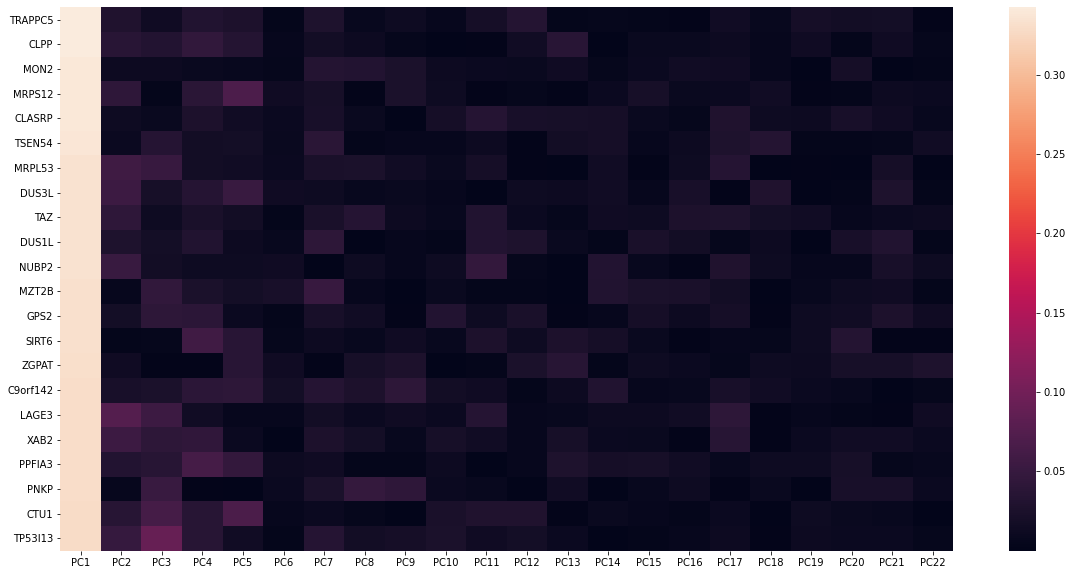

In [164]:
top_exp_df = df_byvar.iloc[0:exp95, 0:exp95]

plt.figure(figsize=(20, 10))
sns.heatmap(top_exp_df)
plt.show()

In [168]:
df_byvar['PC1'][df_byvar['PC1'] > 0.3].shape

(238,)

Вообще как можно видеть, достаточно высокую корреляцию с первой компонентой имеет большое количество генов. Далее при построении модели мы попробуем построить не только модели с использованием всего датасета, но и модели с использованием только топ генов по результатам PCA анализа.

# 3. Модель предсказания ответа на терапию

План такой:

1. Тренировать будем сделующие модели: knn, svm, Decision Tree, Naive Bayes, Random Forest, AdaBoost, XGBoost
2. Проверить дизбаланс классов и при его наличии использовать методику оверсамплинга для его устранения
3. Провести скейлинг данных
4. При помощи grid search и кросс валидации подобрать оптимальные гипер-параметры для каждого из типов моделей
5. Обучить модели
6. Выбрать лучшую, протестировав их на тестовом датасете

В начале обучение проведем для датасета с дублированием 27-го пациента, потом без.

Начнем с проверки дизбаланса классов:

<AxesSubplot:>

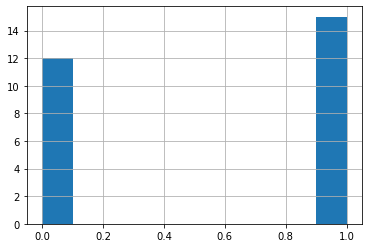

In [411]:
y_train.hist()

Дизбаланс не такой большой, но мы попробуем оверсемплинг, может быть он улучшит результат.

Для оверсемплинга будем использовать метод SMOTE, который делает оверсемплинг с использованием k ближайших соседей. 

Создадим объект для кроссвалидации.

In [193]:
skf = StratifiedKFold(n_splits=5,  random_state=42, shuffle=True)

Для обучения каждой модели создадим пайплайн, в нем будут сделующие шаги:

1. Оверсамплинг
2. Скейлинг 
3. Модель

Также перечислим параметры, которые будут перебираться grid search. Для оценки лучшей модели будем использовать roc_auc score.

In [194]:
# часть пайплайна, общая для всех моделей

base_parameters = {'over__sampling_strategy':(0.9, 1), 
                   'over__k_neighbors':(3, 5, 10)}

def create_base_pipeline(do_scale=True):
    over = SMOTE(sampling_strategy=0.9, k_neighbors=3)
    scale = StandardScaler()
    steps = [('over', over), ('scale', scale)]
    pipeline = Pipeline(steps=steps)
    return pipeline

# добавление модели к пайплайну
def model_pipeline(model, params, do_scale=True):
    pipeline = create_base_pipeline()
    model_parameters = base_parameters.copy()
    model_parameters.update(params)
    pipeline.steps.append(['model', model])
    return pipeline, model_parameters

# поиск лучших параметров модели
def find_best(model_name, model, params, x, y):
    pipeline, parameters = model_pipeline(model, params)
    clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
    _ = clf.fit(x, y)
    print(f'{model_name} best parameters: {clf.best_params_}')

In [465]:
import warnings
warnings.filterwarnings('ignore')

xgb.set_config(verbosity=0)

# определим модели и перебираемые параметры
models = {'KNN': (KNeighborsClassifier(), {'model__n_neighbors': (3, 5, 10, 15)}),
          'SVM': (SVC(), 
                  {'model__kernel':('linear', 'poly', 'rbf'), 
                   'model__degree': (2, 3, 5),}),
          'Decision Tree': (DecisionTreeClassifier(), 
                            {'model__criterion':('gini', 'entropy'), 
                             'model__max_depth': (3, 5, 7, 10)}),
          'Naive Bayes': (GaussianNB(), {}),
          'Random Forest': (RandomForestClassifier(), 
                            {'model__max_depth':(3, 5, 7, 10, None), 
                             'model__n_estimators': (100, 500, 700, 1000),}),
          'AdaBoost': (AdaBoostClassifier(), 
                       {'model__n_estimators': (50, 100, 500, 700, 1000),}),
          'XGBoost': (xgb.XGBClassifier(), 
                      {'model__max_depth': (3, 5, 7, 10, None),
                       'model__n_estimators': (100, 500, 700, 1000)}),
         }

for k in models.keys():
    find_best(k, models[k][0], models[k][1], train, y_train)

KNN best parameters: {'model__n_neighbors': 3, 'over__k_neighbors': 3, 'over__sampling_strategy': 1}
SVM best parameters: {'model__degree': 2, 'model__kernel': 'rbf', 'over__k_neighbors': 3, 'over__sampling_strategy': 1}
Decision Tree best parameters: {'model__criterion': 'gini', 'model__max_depth': 3, 'over__k_neighbors': 3, 'over__sampling_strategy': 0.9}
Naive Bayes best parameters: {'over__k_neighbors': 3, 'over__sampling_strategy': 1}
Random Forest best parameters: {'model__max_depth': 3, 'model__n_estimators': 100, 'over__k_neighbors': 3, 'over__sampling_strategy': 0.9}
AdaBoost best parameters: {'model__n_estimators': 50, 'over__k_neighbors': 3, 'over__sampling_strategy': 0.9}
XGBoost best parameters: {'model__max_depth': 3, 'model__n_estimators': 1000, 'over__k_neighbors': 3, 'over__sampling_strategy': 1}


In [572]:
# создадим модели с лучшими параметрами, обучим их и проверим на тестовом датасете

best_models = [('KNN', KNeighborsClassifier(n_neighbors = 3), SMOTE(sampling_strategy=1, k_neighbors=3)),
               ('SVM', SVC(degree = 2, kernel = 'rbf', probability=True), SMOTE(sampling_strategy=1, k_neighbors=3)),
               ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', max_depth = 3), SMOTE(sampling_strategy=0.9, k_neighbors=3)),
               ('Naive Bayes', GaussianNB(), SMOTE(sampling_strategy=1, k_neighbors=3)),
               ('Random Forest', RandomForestClassifier(max_depth = 3, n_estimators = 100), SMOTE(sampling_strategy=0.9, k_neighbors=3)),
               ('AdaBoost', AdaBoostClassifier(n_estimators = 50), SMOTE(sampling_strategy=0.9, k_neighbors=3)),
               ('XGBoost', xgb.XGBClassifier(max_depth = 3, n_estimators = 1000), SMOTE(sampling_strategy=1, k_neighbors=3)),
              ]

trained_models = {}

for bm in best_models:
    name = bm[0]
    best_model = bm[1]
    best_over = bm[2]
    scale = StandardScaler()
    steps = [('over', best_over), ('scale', scale), ('model', best_model)]
    pipeline = Pipeline(steps=steps)
    _ = pipeline.fit(train, y_train)
    
    trained_models[name] = deepcopy(pipeline)
    
    test_scale = pipeline[-2].transform(test)
    y_test_pred = pipeline[-1].predict(test_scale)
    y_test_pred_proba = pipeline[-1].predict_proba(test_scale)[:,1]
    
    print(f'{name}')
    print(f'Test ROC AUC for the {name} best model %.2f' % roc_auc_score(y_test, y_test_pred_proba))
    print(f'Test F1 for the {name} best model %.2f' % f1_score(y_test, y_test_pred))
    print(f'Test precision for the {name} best model %.2f' % precision_score(y_test, y_test_pred))
    print(f'Test recall for the {name} best model %.2f' % recall_score(y_test, y_test_pred))
    print(f'Test accuracy for the {name} best model %.2f' % accuracy_score(y_test, y_test_pred))
    print(y_test)
    print(y_test_pred)
    print(y_test_pred_proba)
    print()

KNN
Test ROC AUC for the KNN best model 1.00
Test F1 for the KNN best model 0.67
Test precision for the KNN best model 1.00
Test recall for the KNN best model 0.50
Test accuracy for the KNN best model 0.80
[1 1 0 0 0]
[1 0 0 0 0]
[0.66666667 0.33333333 0.         0.         0.        ]

SVM
Test ROC AUC for the SVM best model 1.00
Test F1 for the SVM best model 0.80
Test precision for the SVM best model 0.67
Test recall for the SVM best model 1.00
Test accuracy for the SVM best model 0.80
[1 1 0 0 0]
[1 1 0 1 0]
[0.64692564 0.641011   0.39910788 0.55099492 0.37414892]

Decision Tree
Test ROC AUC for the Decision Tree best model 1.00
Test F1 for the Decision Tree best model 1.00
Test precision for the Decision Tree best model 1.00
Test recall for the Decision Tree best model 1.00
Test accuracy for the Decision Tree best model 1.00
[1 1 0 0 0]
[1 1 0 0 0]
[1. 1. 0. 0. 0.]

Naive Bayes
Test ROC AUC for the Naive Bayes best model 1.00
Test F1 for the Naive Bayes best model 1.00
Test precis

В целом все модели показали неплохой реузльтат, лучше всех отработали: XGBoost, AdaBoost, Random Forest, Naive Bayes, Decision Tree.

Теперь посмотрим на важность фичей различных моделей, основанных на деревьях.

In [573]:
im = []
for n in ['XGBoost', 'AdaBoost', 'Random Forest', 'Decision Tree']:
    importances = trained_models['XGBoost'][-1].feature_importances_
    im.append(importances)

im = np.array(im)

Просуммируем важности всех фичей из разных моделей, чтобы посмотреть какие часще всего являются наиболее важными в разных моделях

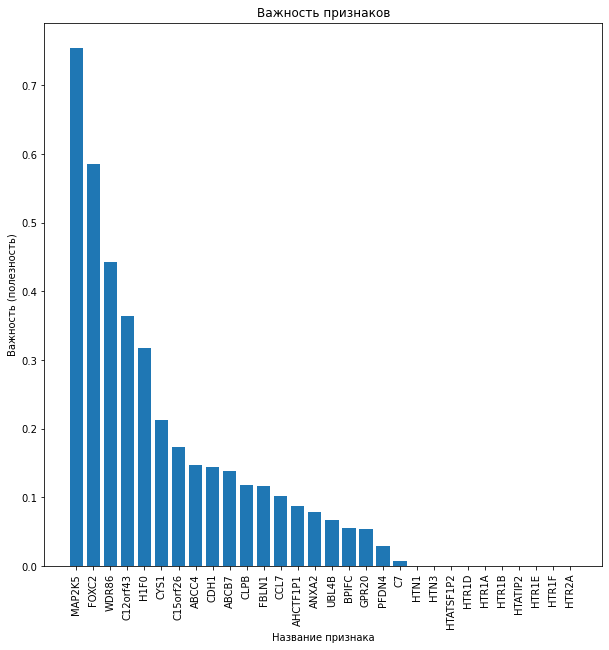

In [574]:
importances = np.sum(im, axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 10))

plt.title('Важность признаков')
plt.ylabel('Важность (полезность)')
plt.xlabel('Название признака')

plt.bar(range(30), importances[indices][0:30])
plt.xticks(range(30), test.columns[indices][0:30], rotation=90)
plt.show()

Можно видеть что одним из наиболее важных генов для определения устойчивости к терапии является MAP2K5.

Это ген кодирующий одну из метоген-активируемых протеинкиназ (MAPK) и в первой из статей указано, что "(MAPK)-targeted therapy (MAPK inhibitor) induces similar signatures in melanoma, suggesting that a non-genomic form of MAPK inhibitor resistance mediates cross-resistance to anti-PD-1 therapy". То есть важность этой фичи имеет смысл.

Вторым по важности геном является FOXC2, кодирующий транскрипционный фактор, есть исследования связывающие его с разрастанием меланомы и сопротивляемости различным методам лечения меланомы: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6885364/

Теперь построим модель, которая будет обучаться только на топ 300 генах отобранных во время PCA:

In [195]:
import warnings
warnings.filterwarnings('ignore')

xgb.set_config(verbosity=0)

# определим модели и перебираемые параметры
models = {'KNN': (KNeighborsClassifier(), {'model__n_neighbors': (3, 5, 10, 15)}),
          'SVM': (SVC(), 
                  {'model__kernel':('linear', 'poly', 'rbf'), 
                   'model__degree': (2, 3, 5),}),
          'Decision Tree': (DecisionTreeClassifier(), 
                            {'model__criterion':('gini', 'entropy'), 
                             'model__max_depth': (3, 5, 7, 10)}),
          'Naive Bayes': (GaussianNB(), {}),
          'Random Forest': (RandomForestClassifier(), 
                            {'model__max_depth':(3, 5, 7, 10, None), 
                             'model__n_estimators': (100, 500, 700, 1000),}),
          'AdaBoost': (AdaBoostClassifier(), 
                       {'model__n_estimators': (50, 100, 500, 700, 1000),}),
          'XGBoost': (xgb.XGBClassifier(), 
                      {'model__max_depth': (3, 5, 7, 10, None),
                       'model__n_estimators': (100, 500, 700, 1000)}),
         }

for k in models.keys():
    find_best(k, models[k][0], models[k][1], train[df_byvar.index[0:300]], y_train)

KNN best parameters: {'model__n_neighbors': 10, 'over__k_neighbors': 3, 'over__sampling_strategy': 1}
SVM best parameters: {'model__degree': 5, 'model__kernel': 'poly', 'over__k_neighbors': 5, 'over__sampling_strategy': 1}
Decision Tree best parameters: {'model__criterion': 'gini', 'model__max_depth': 10, 'over__k_neighbors': 5, 'over__sampling_strategy': 1}
Naive Bayes best parameters: {'over__k_neighbors': 3, 'over__sampling_strategy': 1}
Random Forest best parameters: {'model__max_depth': 10, 'model__n_estimators': 100, 'over__k_neighbors': 3, 'over__sampling_strategy': 1}
AdaBoost best parameters: {'model__n_estimators': 500, 'over__k_neighbors': 3, 'over__sampling_strategy': 1}
XGBoost best parameters: {'model__max_depth': None, 'model__n_estimators': 700, 'over__k_neighbors': 3, 'over__sampling_strategy': 1}


In [205]:
# создадим модели с лучшими параметрами, обучим их и проверим на тестовом датасете

best_models = [('KNN', KNeighborsClassifier(n_neighbors = 10), SMOTE(sampling_strategy=1, k_neighbors=3)),
               ('SVM', SVC(degree = 5, kernel = 'poly', probability=True), SMOTE(sampling_strategy=1, k_neighbors=5)),
               ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', max_depth = 10), SMOTE(sampling_strategy=1, k_neighbors=5)),
               ('Naive Bayes', GaussianNB(), SMOTE(sampling_strategy=1, k_neighbors=3)),
               ('Random Forest', RandomForestClassifier(max_depth = 10, n_estimators = 100), SMOTE(sampling_strategy=1, k_neighbors=3)),
               ('AdaBoost', AdaBoostClassifier(n_estimators = 500), SMOTE(sampling_strategy=1, k_neighbors=3)),
               ('XGBoost', xgb.XGBClassifier(max_depth = None, n_estimators = 700), SMOTE(sampling_strategy=1, k_neighbors=3)),
              ]

trained_models = {}

for bm in best_models:
    name = bm[0]
    best_model = bm[1]
    best_over = bm[2]
    scale = StandardScaler()
    steps = [('over', best_over), ('scale', scale), ('model', best_model)]
    pipeline = Pipeline(steps=steps)
    _ = pipeline.fit(train[df_byvar.index[0:300]], y_train)
    
    trained_models[name] = deepcopy(pipeline)
    
    test_scale = pipeline[-2].transform(test[df_byvar.index[0:300]])
    y_test_pred = pipeline[-1].predict(test_scale)
    y_test_pred_proba = pipeline[-1].predict_proba(test_scale)[:,1]
    
    print(f'{name}')
    print(f'Test ROC AUC for the {name} best model %.2f' % roc_auc_score(y_test, y_test_pred_proba))
    print(f'Test F1 for the {name} best model %.2f' % f1_score(y_test, y_test_pred))
    print(f'Test precision for the {name} best model %.2f' % precision_score(y_test, y_test_pred))
    print(f'Test recall for the {name} best model %.2f' % recall_score(y_test, y_test_pred))
    print(f'Test accuracy for the {name} best model %.2f' % accuracy_score(y_test, y_test_pred))
    print(y_test)
    print(y_test_pred)
    print(y_test_pred_proba)
    print()

KNN
Test ROC AUC for the KNN best model 0.42
Test F1 for the KNN best model 0.00
Test precision for the KNN best model 0.00
Test recall for the KNN best model 0.00
Test accuracy for the KNN best model 0.60
[1 1 0 0 0]
[0 0 0 0 0]
[0.5 0.4 0.5 0.4 0.5]

SVM
Test ROC AUC for the SVM best model 0.00
Test F1 for the SVM best model 0.57
Test precision for the SVM best model 0.40
Test recall for the SVM best model 1.00
Test accuracy for the SVM best model 0.40
[1 1 0 0 0]
[1 1 1 1 1]
[0.48983188 0.4901312  0.49317003 0.49125735 0.49069298]

Decision Tree
Test ROC AUC for the Decision Tree best model 0.58
Test F1 for the Decision Tree best model 0.50
Test precision for the Decision Tree best model 0.50
Test recall for the Decision Tree best model 0.50
Test accuracy for the Decision Tree best model 0.60
[1 1 0 0 0]
[0 1 0 1 0]
[0. 1. 0. 1. 0.]

Naive Bayes
Test ROC AUC for the Naive Bayes best model 0.67
Test F1 for the Naive Bayes best model 0.40
Test precision for the Naive Bayes best model 

Random Forest, XGBoost, AdaBoost по прежнему покзывают хороший результат. Проведем анализ важности признаков:

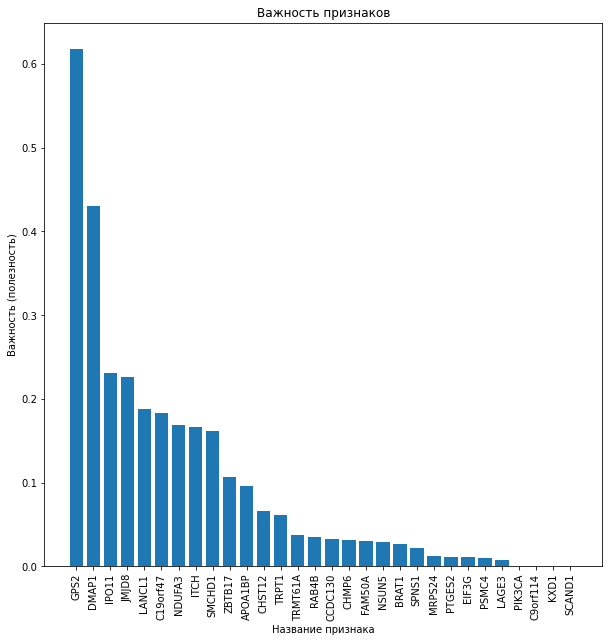

In [207]:
im = []
for n in ['XGBoost', 'AdaBoost', 'Random Forest']:
    importances = trained_models['XGBoost'][-1].feature_importances_
    im.append(importances)

im = np.array(im)

importances = np.sum(im, axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 10))

plt.title('Важность признаков')
plt.ylabel('Важность (полезность)')
plt.xlabel('Название признака')

plt.bar(range(30), importances[indices][0:30])
plt.xticks(range(30), test[df_byvar.index[0:300]].columns[indices][0:30], rotation=90)
plt.show()

Главный по важности GPS2 ген, он также связан с МАРК.

Дальнейший анализ важности генов требует более детального рассмотрения. 

И еще пострим графики экспрессии наиболее важных генов исходя из предыдущего анализа.

<AxesSubplot:ylabel='MAP2K5'>

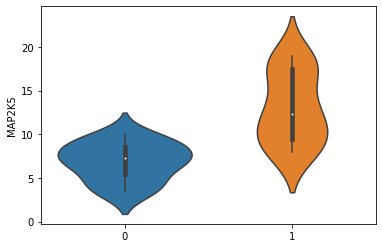

In [216]:
sns.violinplot(x=y_data, y=data['MAP2K5'])

Очевидно, что уровень экспрессии гена MAP2K5 заметно ниже у пациентов без ответа на терапию.

Также этот ген находится среди наиболее значимых по анализу экспрессии генов, проведенном ранее.

<AxesSubplot:ylabel='FOXC2'>

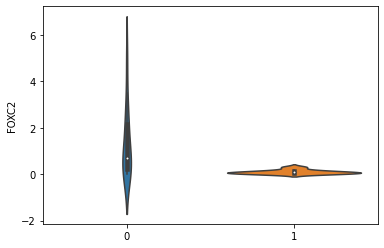

In [218]:
sns.violinplot(x=y_data, y=data['FOXC2'])

Тут тоже разница заметна, хоть и не так сильно

<AxesSubplot:ylabel='GPS2'>

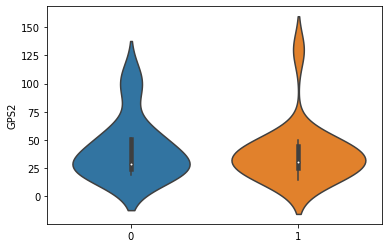

In [224]:
sns.violinplot(x=y_data, y=data['GPS2'])

<AxesSubplot:ylabel='DMAP1'>

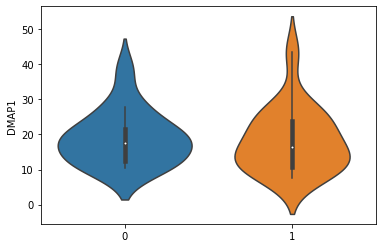

In [228]:
sns.violinplot(x=y_data, y=data['DMAP1'])

По остальным наиболее важным генам такой заметной разницы нет.